#### Load required libraries

In [1]:
import numpy as np
import logging
import pickle
from scipy import sparse
from scipy.linalg import block_diag
import scipy.io as spio

# Define color and marker for analysis plots
markers = ["x", "+", "o"]
colors = ["blue","orange","green","red","purple","brown","pink"]

import os
from os import path

from pathlib import Path
# import DOS library
import dos
import dos.plot_tools as ptools

from ruamel import yaml
from ruamel.yaml import YAML
y = YAML()
y.default_flow_style = None

sim_folder = 'dos/qpAcO'
calibDataFolder = '/Users/rromano/Workspace/SIMCEO/calibration_dbs'

The next two cells are used just in case updates of tool or plot_tools functions 

In [8]:
# Reload plot tools library
import importlib
importlib.reload(dos.plot_tools)

<module 'dos.plot_tools' from '/Users/rromano/Workspace/SIMCEO/dos/plot_tools.py'>

#### Load Active Optics Influence Matrix

In [2]:
# Number of bending modes
n_bm = 27
# Flag to include mount controllable modes
include_mount = False

# Load calibrations data
#dt = np.load(Path(calibDataFolder)/'calib_dt_SH0p5fluxTH_46BM.npz', allow_pickle=True)
dt = np.load(Path(calibDataFolder)/'calib_dt_GSH0p5fluxTH_46BM.npz', allow_pickle=True)

if (0):
    # Relative RBM:BM sensitivity
    norm_RBM = np.linalg.norm(dt['calibdt'][()]['D'][0][:,:12])
    norm_BM = np.linalg.norm(dt['calibdt'][()]['D'][0][:,12:])
    print('Ratio ||BM||/||RBM||:',norm_BM/norm_RBM)
    # M1:M2 sensitivity
    norm_Dm1 = np.linalg.norm(dt['calibdt'][()]['D'][0][:,:6])
    norm_Dm2 = np.linalg.norm(dt['calibdt'][()]['D'][0][:,6:12])
    print('Ratio ||D_m1||/||D_m2||:%0.3g'%(norm_Dm1/norm_Dm2))


# Compute SH-WFS consolidated interaction matrix
Dsh = block_diag(*[Dseg[:,:12+n_bm] for Dseg in dt['calibdt'][()]['D'][:-1]])
Dsh = block_diag(Dsh,dt['calibdt'][()]['D'][-1][:,:10+n_bm])

if include_mount:
    dt_ = np.load('/Users/rromano/Workspace/SIMCEO/calibration_dbs/piston_mount_calib_dt_GSH.npz', 
                 allow_pickle=True)
    Dsh = np.hstack([Dsh, dt_['calibdt'][()]['Dm']])
    if (0):
        U,sigma,V = np.linalg.svd(Dsh[:,:-2], full_matrices=False)        
        print('Weakest singular values :\n',sigma[-15:])
        U_,sigma_,V_ = np.linalg.svd(Dsh, full_matrices=False)
        import matplotlib.pyplot as plt
        plt.figure(figsize=(16,6))    
        plt.semilogy(sigma[:],'s-', label='wo mount')
        plt.semilogy(sigma_[:], 'd-.', label='with mount')
        plt.grid()
        plt.legend()
        plt.xlabel('# Mode')
        plt.ylabel('Dsh singular values')
        plt.show()
        

Functions to compute controllable mode and control balance regularization matrices

In [3]:
def get_aco_recW2(Dsh,wfsMask,rho_p,rho_s):
            
    # - - - Global clocking filtering: we assume that the last 12 modes refer to segment clocking
    n_r = 12
    _U,sigma,VT = np.linalg.svd(Dsh,full_matrices=False)
    q = sigma[-n_r:]
    W2_clk = VT[-n_r:,:].T.dot(np.diag(q)).dot(VT[-n_r:,:])
    
    # - - - Segment piston penalization
    dt_p = np.load('/Users/rromano/Workspace/SIMCEO/calibration_dbs/piston_mount_calib_dt_GSH.npz', 
                 allow_pickle=True)
    Dp = dt_p['calibdt'][()]['Dp']
    
    if not ((Dsh.shape[1]+2) % 7):
        mount_included = False
        n_bm = ((Dsh.shape[1]+2)//7) - 12
    elif not ((Dsh.shape[1]+2 -2) % 7):
        n_bm = ((Dsh.shape[1])//7) - 12
        mount_included = True
    else:
        print('Unable to get the correct number of the calibrated bending modes. Check Dsh!')
    
    # List of outer-axis piston inducing influence matrices
    Dp_list = [* np.split(Dp,np.arange(12,84,12),axis=1)]
    # Include zero columns corresponfing to bending modes 
    Dp1to6 = np.hstack([*[np.append(DpSeg,np.zeros((Dp.shape[0],n_bm)),axis=1) for DpSeg in Dp_list[:-1]]])
    Dp7 = np.append(np.delete(Dp_list[-1],[5,11],axis=1),np.zeros((Dp.shape[0],n_bm)),axis=1)
    DpwBM = np.hstack([Dp1to6,Dp7])
    
    if mount_included:
        Dp_az = dt_p['calibdt'][()]['Dp_az']
        Dp_el = dt_p['calibdt'][()]['Dp_el']
        DpwBM = np.hstack([DpwBM, Dp_az, Dp_el])
        
    W2_piston = DpwBM.T.dot(DpwBM)

    if(0):
        import matplotlib.pyplot as plt
        fig = plt.figure(figsize=(8,4))
        plt.imshow(W2_piston[:,:],aspect='auto')
        plt.show()
    
    # - - - Mean slope removal matrices (and retains the overall contribution)
    O = np.kron(np.eye(6),np.ones((48*48,1)))
    V_pr = np.zeros((Dsh.shape[0],6))
    for iv in range(6):
        V_pr[:,iv] = np.hstack([*[O[MaskSeg.ravel(),iv] for MaskSeg in wfsMask]])
    Lambda_pr = np.diag(1/np.sum(V_pr,axis=0))
    
    R_g = np.kron(np.eye(2),np.array([[1,1,1]]).T)
    Lambda_g = np.diag(1/np.sum(V_pr@R_g,axis=0))    
    S = np.matmul(V_pr @ (Lambda_pr - R_g@Lambda_g@R_g.T) @ V_pr.T, Dsh)
    

    if(0):
        import matplotlib.pyplot as plt
        fig = plt.figure(figsize=(8,4))
        plt.imshow((V_pr @ (Lambda_pr - R_g@Lambda_g@R_g.T) @ V_pr.T),aspect='auto')
        plt.show()
    # Mean slope regularization matrix
    W2_mslope = S.T.dot(S)
    
    W2 = W2_clk + rho_p*W2_piston + rho_s*W2_mslope
    Rs = np.eye(Dsh.shape[0]) - (V_pr @ (Lambda_pr - R_g@Lambda_g@R_g.T) @ V_pr.T)
    return W2, Rs


In [4]:
def get_aco_recW3(rho_rbm1,rho_rbm2,rho_Fz,**kwargs):
    
    W_M1TxyzRxyz = [rho_rbm1*i_cm for i_cm in [1]*6]
    W_M2TxyzRxyz = [rho_rbm2*i_cm for i_cm in [1]*6]
    
    W_rbm_oa = block_diag(np.diag(W_M1TxyzRxyz), np.diag(W_M2TxyzRxyz))
    W_rbm_cs = block_diag(np.diag(W_M1TxyzRxyz[:-1]), np.diag(W_M2TxyzRxyz[:-1]))
    
    # OA segment weights
    W_m1oaF = np.diag([1]*165)
    W_m1oaF =  rho_Fz*(1/np.linalg.norm(W_m1oaF))*W_m1oaF
    # CS (center segment) weights
    W_m1csF = np.diag([1]*154)
    W_m1csF =  rho_Fz*(1/np.linalg.norm(W_m1csF))*W_m1csF

    # Rescale RBM weighting matrix
    rbm_factor = 1/np.linalg.norm(W_rbm_oa) 
    # Merge weighting matrices
    W3_oa = block_diag(rbm_factor*W_rbm_oa,W_m1oaF)
    W3_cs = block_diag(rbm_factor*W_rbm_cs,W_m1csF)
    W3 = block_diag(np.kron(np.eye(6),W3_oa),W3_cs)
    if 'rho_m' in kwargs.keys():
        W3 = block_diag(W3,kwargs['rho_m']*np.eye(2))
    
    W3 = (1/np.linalg.norm(W3))*W3
    
    return W3



#### AcO reconstructor+controller settings

In [14]:
# Maximmum actuator command values
max_m1RBM = [3.0e-3,4.75e-3,4e-3] + [6.5e-4,5.75e-4,5.75e-4]
max_m2RBM = [3.0e-5,3.0e-5,3.0e-5] + [3.5e-3,3.5e-3,3.5e-3]
max_Fz = 147
max_az_el = [1e-2,1e-2]

# Get weighting matrices
W2, Rs = get_aco_recW2(Dsh,dt['calibdt'][()]['wfsMask'],rho_p=1.0e-5,rho_s=1.0e-8)
W3 = get_aco_recW3(rho_rbm1=4, rho_rbm2=1, rho_Fz=0.1*(12/165)**2)
if include_mount:
    W3 = get_aco_recW3(rho_rbm1=4, rho_rbm2=1, rho_Fz=0.1*(12/165)**2, rho_m=50)

# Print reconstructor regularization weights
if(1):
    np.set_printoptions(formatter={'float': '{: 0.6f}'.format})
    
    aux = np.insert(np.diag(W3),[72+(165*6)+5,72+(165*6)+10],0)
    if include_mount:
        print('Mount weights:\n',aux[-2:])
        aux = np.reshape(np.append(aux[:-2],np.array([0]*11)),[7,12+165])
    else:
        aux = np.reshape(np.append(aux,np.array([0]*11)),[7,12+165])    
        
    _wM1rbm,_wM2rbm,_wBM = np.split(aux,[6,12],axis=1)
    print('M1/TxyzRxyz weights:\n',_wM1rbm[[0,6]])
    print('M2/TxyzRxyz weights:\n',_wM2rbm[[0,6]])
    print('Fz weights:\n',_wBM[0,:5],'...')
    np.set_printoptions(formatter=None)


# Bending modes' data
Afz = {}
# OA segment weights
filepath = os.path.join('../ActiveOptics','Af_oa_axial_ver3.mat')
Afz['outer'] = spio.loadmat(filepath)['afprime']
_U,s_oa,V_oaT = np.linalg.svd(Afz['outer'],0)
bm2Fz_oa = np.dot(V_oaT.T, np.diag(1/s_oa)[:,:n_bm])
# CS (center segment) weights
filepath = os.path.join('../ActiveOptics','Af_cs154_axial.mat')
Afz['center'] = spio.loadmat(filepath)['afprime']
_U,s_cs,V_csT = np.linalg.svd(Afz['center'],0)
bm2Fz_cs = np.dot(V_csT.T, np.diag(1/s_cs)[:,:n_bm])


# Transformation matrix from ctrlb modes to actuator action domain
fz_factor = np.mean(max_m1RBM + max_m2RBM)/max_Fz
_Tu = block_diag(np.kron(np.eye(6),block_diag(np.eye(12),fz_factor*bm2Fz_oa)),
                 block_diag(np.eye(12),fz_factor*bm2Fz_cs))
_TuwoS7Rz = block_diag(np.kron(np.eye(6),block_diag(np.eye(12),fz_factor*bm2Fz_oa)),
                 block_diag(np.eye(10),fz_factor*bm2Fz_cs))

# OA and CS actuator ranges: for each segment M1RBM-M2RBM-M1BM
rbm_ranges = max_m1RBM+max_m2RBM
oa_ranges = np.array(rbm_ranges + [fz_factor*max_Fz]*bm2Fz_oa.shape[0])
cs_ranges = np.array(rbm_ranges + [fz_factor*max_Fz]*bm2Fz_cs.shape[0])
# Control action upper limits vector
umax = np.hstack([np.kron(np.array([1]*6),oa_ranges),cs_ranges]) # np.array([]) #
    
if include_mount:
    _Tu = block_diag(_Tu,np.eye(2))
    _TuwoS7Rz = block_diag(_TuwoS7Rz,np.eye(2))
    umax = np.hstack([umax, np.array(max_az_el)]) # np.array([]) #

# AcO integral controller gain
K = 0.5

# Active Optics dictionary data
W3 = _TuwoS7Rz.T @ W3 @ _TuwoS7Rz
data = {'SHAcO_qp':{'D':Dwfs,'W2':W2,'W3':W3,'K':K,
                    'wfsMask':dt['calibdt'][()]['wfsMask'],
                    'umin':-umax, 'umax':umax,'rm_mean_slopes':True,
                    '_Tu':_Tu}} #'rho_3':rho_3, 'J1_J3_ratio':10
# Pickles MPC data into string representation
with open(Path(sim_folder)/'SHAcO_qp.pickle','wb') as f:
    pickle.dump(data,f)
    

M1/TxyzRxyz weights:
 [[ 0.151511  0.151511  0.151511  0.151511  0.151511  0.151511]
 [ 0.151511  0.151511  0.151511  0.151511  0.151511  0.000000]]
M2/TxyzRxyz weights:
 [[ 0.037878  0.037878  0.037878  0.037878  0.037878  0.037878]
 [ 0.037878  0.037878  0.037878  0.037878  0.037878  0.000000]]
Fz weights:
 [ 0.000016  0.000016  0.000016  0.000016  0.000016] ...


Check conditioning improvement due to regularization

In [15]:
Ds = Rs.dot(Dsh)
condDTD = np.linalg.cond(Dsh.T.dot(Dsh))
print('Condition number improvement:\n')
print('Due to mean slope removal:',condDTD/np.linalg.cond(Ds.T.dot(Ds)))
print('Due to W2:',condDTD/np.linalg.cond(Ds.T.dot(Ds)+W2))
print('Due to W2 and W3:',condDTD/np.linalg.cond(Ds.T.dot(Ds)+W2+1.0e-6*K*W3*K))

Condition number improvement:

Due to mean slope removal: 1.000048689449018
Due to W2: 394.0339171720464
Due to W2 and W3: 4897.892728847152


#### Get initial M1/M2 states and generate respective yaml files

In [16]:
# Python code to set simulation states
from ruamel import yaml
from ruamel.yaml import YAML
m1m2load_folder = 'testDT/M1M2_loads'
r_id = 1

test_case = 'random' # 'random_RBM' # 'BM_dist' #

if(test_case == 'BM_dist'):
    fileSTR = '_2_3bm'
elif(test_case == 'random_RBM'):
    fileSTR = '_rand_rbm_%d' %r_id
elif(test_case == 'random'):
    fileSTR = '_rbmplusbm_%d' %r_id
else:
    fileSTR = '_noload' %r_id

print('M1 & M2 static load case:',fileSTR)

with open(Path(m1m2load_folder)/('M1'+fileSTR+'.yaml'),'r') as f:
    m1_x0_dt = yaml.safe_load(f)
with open(Path(m1m2load_folder)/('M2'+fileSTR+'.yaml'),'r') as f:
    m2_x0_dt = yaml.safe_load(f)
   
 
# Update yaml files with M1/M2 initial conditions    
with open(Path(sim_folder)/'M1.yaml','w') as f:
        y.dump(m1_x0_dt, f)
with open(Path(sim_folder)/'M2.yaml','w') as f:
        y.dump(m2_x0_dt, f)
    

M1 & M2 static load case: _rbmplusbm_1


#### Instantiate DOS

In [17]:
sim = dos.DOS(sim_folder, verbose=logging.INFO, show_timing=2)

INFO:DOS:Reading config from dos/qpAcO/dos.yaml
INFO:DOS:New driver: M1
INFO:M1:New input: Txyz
INFO:M1:New input: Rxyz
INFO:M1:New input: modes
INFO:M1:No inputs!
INFO:DOS:New driver: M2
INFO:M2:New input: Txyz
INFO:M2:New input: Rxyz
INFO:M2:No inputs!
INFO:DOS:New driver: wfs48
INFO:wfs48:No inputs!
INFO:wfs48:New output: data
INFO:wfs48:New output: M12_RBM
INFO:wfs48:Output logged in!
INFO:DOS:New driver: SHAcO_qp
INFO:SHAcO_qp:New input: wfs48 data
INFO:SHAcO_qp:New output: M1 Txyz
INFO:SHAcO_qp:Output logged in!
INFO:SHAcO_qp:New output: M1 Rxyz
INFO:SHAcO_qp:Output logged in!
INFO:SHAcO_qp:New output: M2 Txyz
INFO:SHAcO_qp:Output logged in!
INFO:SHAcO_qp:New output: M2 Rxyz
INFO:SHAcO_qp:Output logged in!
INFO:SHAcO_qp:New output: M1 BM
INFO:SHAcO_qp:Output logged in!
INFO:DOS:New driver: science
INFO:science:No inputs!
INFO:science:New output: wfe_rms
INFO:science:Output logged in!
INFO:science:New output: segment_wfe_rms
INFO:science:Output logged in!
INFO:science:New output: 

SIMCEO server received: Acknowledging connection from SIMCEO client!


INFO:DOS:Simulation setup for a duration of 50s @ 1Hz (50 steps)!


In [18]:
# Start simulation
#sim.start()
sim._run_()

INFO:DOS:Pushing configuration to server
INFO:M1:GMT
INFO:M2:GMT
INFO:wfs48:OP0
INFO:science:OP1
INFO:DOS:Initializing
INFO:M1:None
INFO:M2:None
INFO:wfs48:None
INFO:science:None
INFO:DOS:Running
INFO:SHAcO_qp:1st-> J1:1.11e-12, J3:5.26e-10, ratio:2.12, ||s||:1.74e-08
INFO:SHAcO_qp:2nd> J1:1.11e-12, J3:5.47e-10, ratio:9.53, rho3:0.000212
INFO:SHAcO_qp:1st-> J1:8.15e-13, J3:1.17e-09, ratio:3.29, ||s||:4.08e-09
INFO:SHAcO_qp:2nd> J1:8.11e-13, J3:1.2e-09, ratio:9.73, rho3:6.98e-05
INFO:SHAcO_qp:1st-> J1:7.24e-13, J3:1.59e-09, ratio:6.54, ||s||:9.61e-10
INFO:SHAcO_qp:2nd> J1:7.23e-13, J3:1.6e-09, ratio:9.88, rho3:4.56e-05
INFO:SHAcO_qp:1st-> J1:6.77e-13, J3:1.8e-09, ratio:8.24, ||s||:2.25e-10
INFO:SHAcO_qp:2nd> J1:6.77e-13, J3:1.8e-09, ratio:9.97, rho3:3.76e-05
INFO:SHAcO_qp:1st-> J1:6.46e-13, J3:1.88e-09, ratio:9.13, ||s||:5.37e-11
INFO:SHAcO_qp:2nd> J1:6.46e-13, J3:1.88e-09, ratio:9.99, rho3:3.43e-05
INFO:SHAcO_qp:1st-> J1:6.57e-13, J3:1.93e-09, ratio:9.94, ||s||:1.31e-11
INFO:SHAcO_qp:2

Elapsed time: 35.8503851890564


INFO:science:OpticalPath deleted!


In [19]:
sim.pctComplete

100

### Image quality metrics

In [20]:
sim.logs

The 'logs' has 12 entries:
 * wfs48
   1. M12_RBM: (273,)x50
 * SHAcO_qp
   1. M1 Txyz: (7, 3)x50
   2. M1 Rxyz: (7, 3)x50
   3. M2 Txyz: (7, 3)x50
   4. M2 Rxyz: (7, 3)x50
   5. M1 BM: (7, 27)x50
 * science
   1. wfe_rms: (1,)x50
   2. segment_wfe_rms: (7,)x50
   3. PSSn: (1,)x50
   4. tiptilt: (2,)x50
   5. segment_piston: (7,)x50
   6. segment_tiptilt: (14,)x50

In [21]:
np.set_printoptions(formatter={'float': '{: 0.4f}'.format})
print(sim.logs.entries['science']['wfe_rms'].timeSeries[1][0,:]*1.0e9)
print('Seg WFE RMS (um):\n',sim.logs.entries['science']['segment_wfe_rms'].timeSeries[1][0,:]*1.0e6)

[ 5916.8988]
Seg WFE RMS (um):
 [ 2.0397  4.2390  2.9148  3.8868  3.8921  3.6269  4.3081]


#### GS = 16 : (Random) RBM load test


Final values:
 WFE (nm): [ 682.3994] 
 [ 1.4883  1.5462  1.4625  1.1371  0.7960  1.3913  1.0919] 
PSSn: [ 1.0000] 
sum of abs seg piston (um): 4.45069585452984 
 [ 0.8693 -0.6127 -0.8777  0.3069  0.6251 -0.8721  0.2869]


(<Figure size 864x432 with 5 Axes>, <Figure size 864x144 with 2 Axes>)

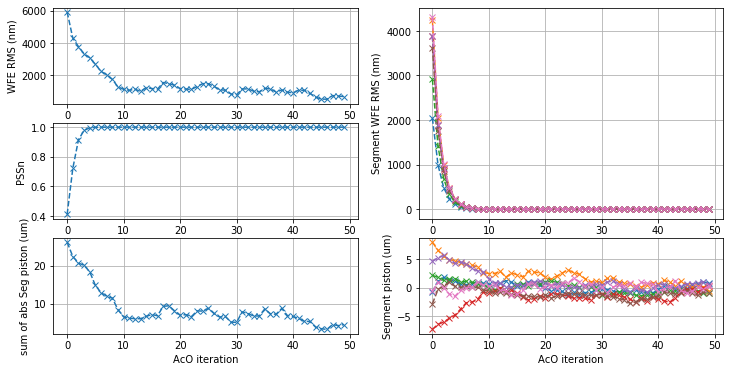

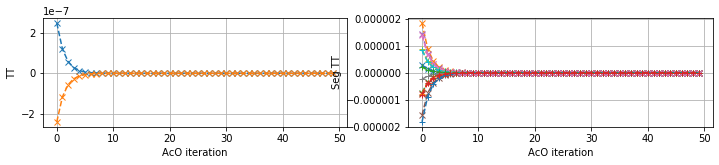

In [22]:
ptools.plot_science(sim.logs.entries['science'], m1EsDT=[])

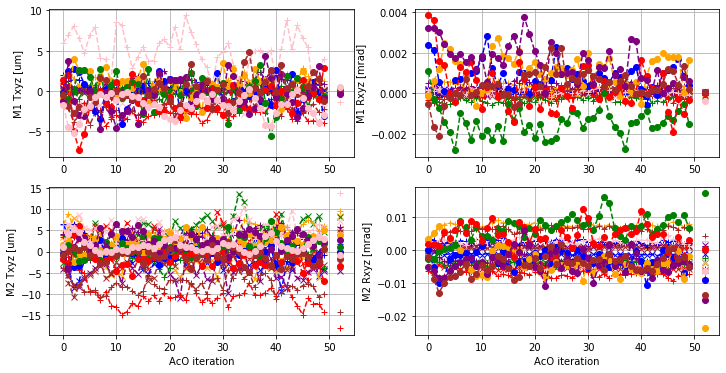

(<Figure size 864x432 with 4 Axes>, <Figure size 864x144 with 1 Axes>)

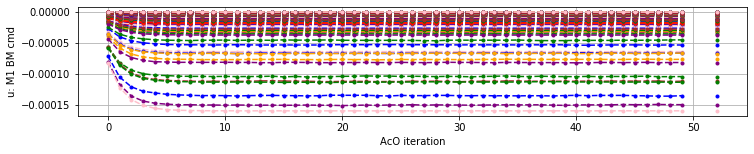

In [23]:
U = sim.logs.entries['SHAcO_qp']
show_delta = False
ptools.plot_X0loadComp(m1_x0_dt, m2_x0_dt, U, show_delta, colors, markers, rm_samples=0)

With mount


Final values:
 WFE (nm): [1722.5523834] 
 [113.90133636 113.07807313 115.2236635  114.72824468 113.36170758
 115.46869416 121.62746543] 
PSSn: [0.9999993] 
sum of abs seg piston (um): 10.668924971923843 
 [ 1.05373726  3.11596841 -0.47997167 -2.02566298 -1.1642843  -1.52448547
  1.30481487]


(<Figure size 864x432 with 5 Axes>, <Figure size 864x144 with 2 Axes>)

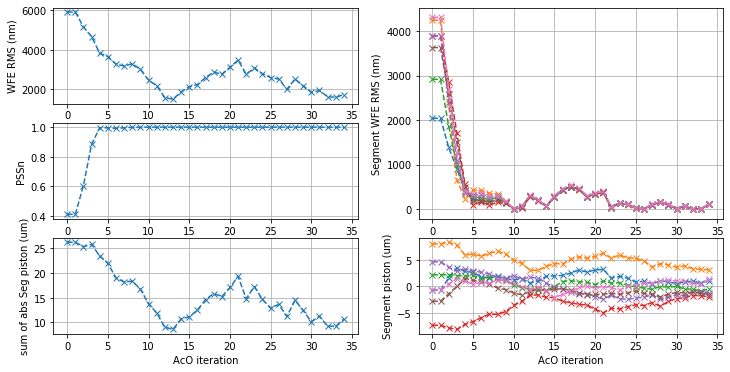

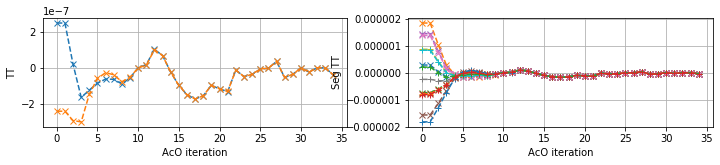

In [19]:
ptools.plot_science(sim.logs.entries['science'], m1EsDT=[])

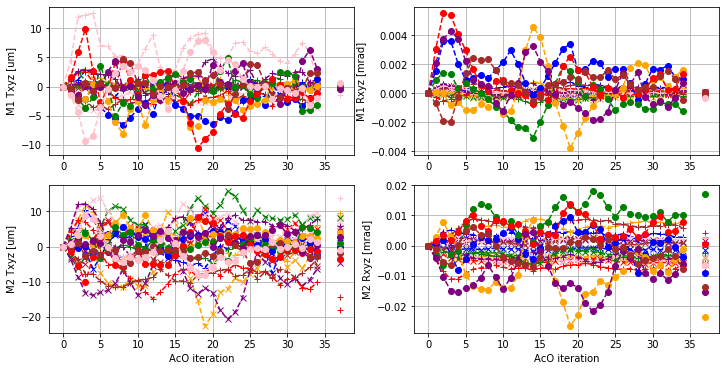

(<Figure size 864x432 with 4 Axes>, <Figure size 864x144 with 1 Axes>)

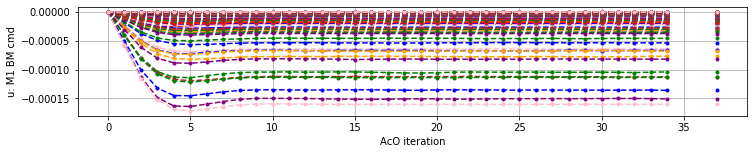

In [20]:
U = sim.logs.entries['SHAcO_qp']
show_delta = False
ptools.plot_X0loadComp(m1_x0_dt, m2_x0_dt, U, show_delta, colors, markers, rm_samples=0)

Some code to check HP displacements

In [22]:
import scipy.io
if 'CG2HP' not in locals():
    CG2HP = scipy.io.loadmat('../ActiveOptics/CG2HP.mat')

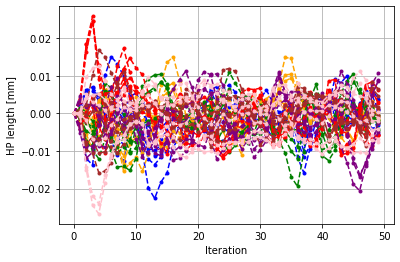

In [23]:
U = sim.logs.entries['SHAcO_qp']
#CG2HP['CG2HP_d'][0][0].shape
import matplotlib.pyplot as plt

m1_hp_d = []
for kk in range(7):
    m1TxyzRxyz = np.split(np.hstack([U['M1 Txyz'].timeSeries[1],
                                     U['M1 Rxyz'].timeSeries[1]]),7,axis=0)
    m1_hp_d.append(np.squeeze(CG2HP['CG2HP_d'][0][kk].dot(m1TxyzRxyz[kk])))
    plt.plot(m1_hp_d[kk].T*1.0e3,'.--', color = colors[kk])
plt.ylabel('HP length [mm]')
plt.xlabel('Iteration')
plt.grid()    

### Actuator force test

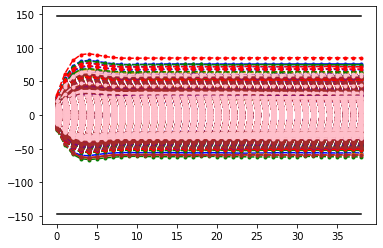

In [24]:
import matplotlib.pyplot as plt

BM_ = sim.logs.entries['SHAcO_qp']['M1 BM'].timeSeries
k_max = 40

for kseg in range(6):
    plt.plot(bm2Fz_oa.dot(BM_[1][kseg,:,1:k_max]).T,'--.',color=colors[kseg])
plt.plot(bm2Fz_cs.dot(BM_[1][6,:,1:k_max]).T,'--.',color=colors[6])
plt.plot(max_Fz*np.ones(BM_[0][1:k_max].shape),'k')
plt.plot(-max_Fz*np.ones(BM_[0][1:k_max].shape),'k')
plt.show()

Some code to test force saturation effects: compare with to without QP

norm of I-T1*T2: 11.75
80.18043506382881 80.18043506382881 80.18043506382877


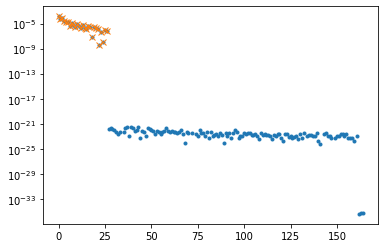

In [102]:
#U_sat.shape, Fz2bm.shape, bm_sat.shape
_U,s_oa,V_oaT = np.linalg.svd(Afz['outer'],0)
isigma = np.zeros_like(s_oa)
n_bm = 27
isigma[:n_bm] = 1/s_oa[:n_bm]

T1 = np.dot(V_oaT.T, np.diag(isigma))
T2 = np.dot(np.diag(s_oa),V_oaT)
print('norm of I-T1*T2: %0.4g'%np.linalg.norm(np.eye(165)-T1.dot(T2)))

U_ = bm2Fz_oa.dot(BM_[1][0,:,4])
U_sat = np.clip(U_, -np.array([max_Fz]*bm2Fz_oa.shape[0]), np.array([max_Fz]*bm2Fz_oa.shape[0]))
bm_sat = T2.dot(U_sat)
bm_sat_reg = np.zeros_like(s_oa)
bm_sat_reg[:n_bm] = bm_sat[:n_bm]
print(max(U_sat), max(U_), max(T1.dot(bm_sat)))

plt.semilogy(np.abs(bm_sat),'.')
plt.semilogy(np.abs(bm_sat_reg),'x')